## Problem 2: 
### Anita Mezzetti

See PDF file for details

This problem is similar to the last assignment. However, while there data were given in the form _(node, sample, time)_, here we have _(time, sample, node)_.  We can proceed in two ways: we can change the algorithm from the last assignment to adapt it to the new form our we can resample our data in order to use the same algorithm. Both ways give the same result.

Some function are equal in both ways. We rewrite them in both cases to make steps clearer :)

index:
1. [Changing the algorithm](#one)
2. [Resampling data](#22)

In [1]:
import numpy as np
from scipy.io import loadmat
import networkx as nx
import math
from scipy.linalg import inv, det
import matplotlib.pyplot as plt
from random import randint

np.set_printoptions(precision=4, linewidth=100)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## 1. Changing the algorithm <a name="one"></a>

Data:

In [2]:
XX = loadmat("market.mat")['DI']
threshold = 0.45

XX.shape

(7, 190, 12)

In [3]:
num_companies = list(XX.shape)[2] # num companies
T = list(XX.shape)[0]

n_sample = list(XX.shape)[1]

nodes = set(range(num_companies))

all_stocks = {1:"Apple Inc", 2:"Cisco Systems", 3:"Dell inc.", 4:"EMC Corporation", 5:"Google Inc.", 6:"Hewlett-Packard", 7:"Intel", 8:"Microsoft", 9:"Oracle", 10:"International Business Machines", 11:"Texas Instruments", 12:"Xerox"}

Our nodes/companies:

In [4]:
set(all_stocks.keys())

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

Adapted function to find $|\Sigma_{x_{0}^{x_{t0}}y_{0}^{y_{t0}}z_{0}^{z_{t0}}}|$ with data in the form _(time, sample, node)_:

In [5]:
def det_cov_adapted(y, y_to, z, z_to, x=-1, x_to=0):
    #print(f"\n y:{y} ytime:{y_to} z:{z} ztime:{z_to} x:{x} xtime:{x_to}")
    
    data = XX[ :y_to+1, :,y]
    #print(f"shape data y: {data.shape}")
    
    if x >= 0:
        data = np.concatenate((XX[:x_to+1, :, x], data))
        #print(f"shape data x: {data.shape}")
    
    z = XX[:z_to+1, :, sorted(z)]
    #print(f"shape data z1     : {z.shape}")
    
    # right dimension
    ash = z.shape
    Z = z[:,:,0]
    for deep in range(ash[2])[1:]:
        Z = np.concatenate((Z, z[:,:,deep]))
    
    #print(f"shape data z     : {Z.shape}")
    
    data = np.concatenate((data, Z))
    #print(f"shape data: {data.shape}")
    
    return  (det(np.cov(data)))

Function to calculate each addend:

In [6]:
def log_part(x, y, z, t):
    A = det_cov_adapted(y, t, z, t-1) * 10**50
    B = det_cov_adapted(y, t-1, z, t-1, x, t-1) * 10**50
    C = det_cov_adapted(y, t-1, z, t-1) * 10**50
    D = det_cov_adapted(y, t, z, t-1, x, t-1) * 10**50
    #print(f"A {A}, B {B}, C {C}, D {D}") 
    return np.log(A*B / (C*D))

Function to compute $I(x \rightarrow y|z)$:

In [7]:
def direct_information(x, y, z):
    return 0.5 * sum(log_part(x, y, z, t) for t in range(1, T))

In [8]:
ALL_IDX = set(range(num_companies))
G = nx.DiGraph()
G.add_nodes_from(list(all_stocks.keys()))

di_matrix = np.zeros((num_companies, num_companies))

Let's now compute learn the causal structure of the graph:

In [9]:
for x in ALL_IDX:
    for y in ALL_IDX:
        if x == y:
            continue

    #if x==1 and y==2:
        di = direct_information(x, y, ALL_IDX - {x, y})
        di_matrix[x, y] = di
        #print(f"I({x}->{y}||{ALL_IDX - {x, y}}) = {di}")
        if di > threshold:
            #print("add an edge between ", x, "and", y)
            G.add_edge(x+1, y+1)

In [10]:
di_matrix

array([[0.    , 0.2822, 0.25  , 0.2898, 0.4662, 0.4994, 0.6375, 0.6783, 0.552 , 0.3831, 0.3804,
        0.1751],
       [0.337 , 0.    , 0.2505, 0.4276, 0.3191, 0.2553, 0.0866, 0.2905, 0.2434, 0.1913, 0.1743,
        0.1593],
       [0.2117, 0.384 , 0.    , 0.1613, 0.5707, 0.1427, 0.2337, 0.3998, 0.2491, 0.4364, 0.3451,
        0.2761],
       [0.2003, 0.1812, 0.3184, 0.    , 0.2768, 0.1586, 0.2383, 0.3086, 0.4202, 0.2524, 0.2068,
        0.2775],
       [0.3438, 0.2743, 0.2661, 0.3364, 0.    , 0.2648, 0.3165, 0.299 , 0.3374, 0.3986, 0.3649,
        0.2471],
       [0.35  , 0.4154, 0.2005, 0.3402, 0.3004, 0.    , 0.1975, 0.6353, 0.2237, 0.4245, 0.248 ,
        0.3272],
       [0.1482, 0.3366, 0.3127, 0.3229, 0.1317, 0.2978, 0.    , 0.1791, 0.1982, 0.2137, 0.3505,
        0.2453],
       [0.4803, 0.5482, 0.3399, 0.36  , 0.542 , 0.2101, 0.368 , 0.    , 0.2048, 0.2843, 0.3815,
        0.4082],
       [0.4363, 0.3419, 0.2499, 0.0996, 0.3187, 0.1315, 0.3177, 0.1986, 0.    , 0.2685, 0.2729,


In [11]:
with open('outfile.txt','wb') as f:
    for line in di_matrix:
        np.savetxt(f, line, fmt='%.2f')

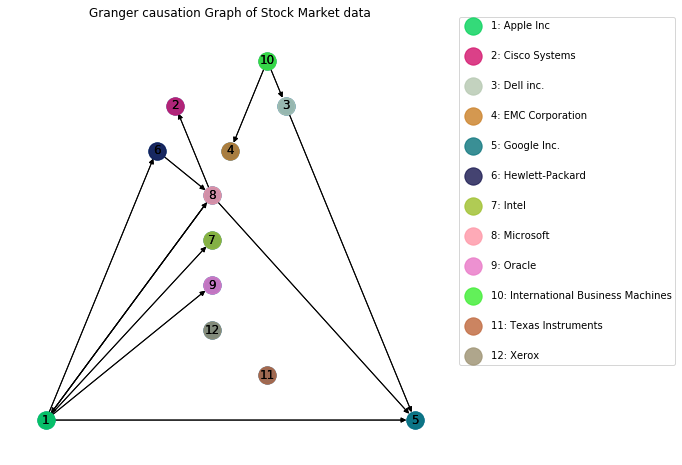

In [13]:
# colors 
colors = []
for i in range(num_companies):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

#for the legend we need inverse dictionary
inv_map = {v: k for k, v in all_stocks.items()}
nodeColorDict = dict(zip(inv_map, colors))


fig, ax = plt.subplots(1, figsize=(8,8))

if nx.check_planarity(G, counterexample=False)[0] == True: # if planar
    pos = nx.planar_layout(G)
    nx.draw(G, pos=pos, with_labels=True)
else: # if not planar
    pos = nx.draw_networkx(G)
    
for nt in inv_map:
    nlist = inv_map[nt]
    ncolor = nodeColorDict[nt] # node color
    nx.draw_networkx_nodes(G, 
                           pos=pos,
                           nodelist= [nlist],
                           ax=ax, 
                           node_color=ncolor,
                           label='{num}: {nt}'.format(nt=nt, num=nlist),
                           alpha=0.8)
h2 = nx.draw_networkx_edges(G, pos=pos)
h3 = nx.draw_networkx_labels(G, pos=pos)
ax.legend(scatterpoints=1, bbox_to_anchor=(1,1.025),loc="upper left", labelspacing=2)
plt.title("Granger causation Graph of Stock Market data")
plt.show()



In [14]:
XX = loadmat("market.mat")['DI']

print(XX.shape)


(7, 190, 12)


## 2. Resampling Data <a name="22"></a>

Reshape:

In [15]:
XX = loadmat("market.mat")['DI']

XX = np.transpose(XX, axes=[2, 1, 0])

print(XX.shape)


(12, 190, 7)


In [16]:
def det_cov(y, y_to, z, z_to, x=-1, x_to=0):
    
    data = XX[y, :, :y_to+1].T # note: we write y_to+1 otherwise the :y_to would stop to y_to-1
    if x >= 0:
        data = np.concatenate((XX[x, :, :x_to+1].T, data))
        
    Z = np.transpose(XX[sorted(z), :, :z_to+1], axes=[0, 2, 1]).reshape(-1, n_sample)
    data = np.concatenate((data, Z))

    return det(np.cov(data))

Then we define a method that gets the log part of the equation that for convenience we rename $log \frac{A \cdot B}{C \cdot D}$

In [17]:
def log_part(x, y, z, t):
    A = det_cov(y, t, z, t-1) * 10**50
    B = det_cov(y, t-1, z, t-1, x, t-1) * 10**50
    C = det_cov(y, t-1, z, t-1) * 10**50
    D = det_cov(y, t, z, t-1, x, t-1) * 10**50
    #print(f"A {A}, B {B}, C {C}, D {D}") 
    return np.log(A*B / (C*D))

Then we define a method that computes the direct information

In [18]:
def direct_information(x, y, z):
    return 0.5 * sum(log_part(x, y, z, t) for t in range(1, T))

In [19]:
ALL_IDX = set(range(num_companies))
G = nx.DiGraph()
G.add_nodes_from(list(all_stocks.keys()))

di_matrix = np.zeros((num_companies, num_companies))

Let's now compute learn the causal structure of the graph. We add an edge if $I(X \to Y || Z) > 0.6$

In [20]:
for x in ALL_IDX:
    for y in ALL_IDX:
        if x == y:
            continue
        di = direct_information(x, y, ALL_IDX - {x, y})
        di_matrix[x, y] = di
        print(f"I({x+1}->{y+1}||{set([x+1 for x in ALL_IDX]) - {x, y}}) = {di}")
        if di > threshold:
            #print("add an edge between ", x, "and", y)
            G.add_edge(x+1, y+1)

I(1->2||{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}) = 0.28222781013114623
I(1->3||{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}) = 0.25001480525211295
I(1->4||{1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12}) = 0.289779713169844
I(1->5||{1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12}) = 0.4662251983692426
I(1->6||{1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12}) = 0.4994128736397288
I(1->7||{1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12}) = 0.6374652463552616
I(1->8||{1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12}) = 0.6782549359085784
I(1->9||{1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12}) = 0.5520297393663178
I(1->10||{1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12}) = 0.38308353450587107
I(1->11||{1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12}) = 0.3804028154372441
I(1->12||{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12}) = 0.17506559830107105
I(2->1||{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}) = 0.3369562400403786
I(2->3||{3, 4, 5, 6, 7, 8, 9, 10, 11, 12}) = 0.2505020781345785
I(2->4||{2, 4, 5, 6, 7, 8, 9, 10, 11, 12}) = 0.42764069939660976
I(2->5||{2, 3, 5, 6, 7, 8, 9, 10, 11, 12}) = 0.3191155932698274

In [21]:
di_matrix

array([[0.    , 0.2822, 0.25  , 0.2898, 0.4662, 0.4994, 0.6375, 0.6783, 0.552 , 0.3831, 0.3804,
        0.1751],
       [0.337 , 0.    , 0.2505, 0.4276, 0.3191, 0.2553, 0.0866, 0.2905, 0.2434, 0.1913, 0.1743,
        0.1593],
       [0.2117, 0.384 , 0.    , 0.1613, 0.5707, 0.1427, 0.2337, 0.3998, 0.2491, 0.4364, 0.3451,
        0.2761],
       [0.2003, 0.1812, 0.3184, 0.    , 0.2768, 0.1586, 0.2383, 0.3086, 0.4202, 0.2524, 0.2068,
        0.2775],
       [0.3438, 0.2743, 0.2661, 0.3364, 0.    , 0.2648, 0.3165, 0.299 , 0.3374, 0.3986, 0.3649,
        0.2471],
       [0.35  , 0.4154, 0.2005, 0.3402, 0.3004, 0.    , 0.1975, 0.6353, 0.2237, 0.4245, 0.248 ,
        0.3272],
       [0.1482, 0.3366, 0.3127, 0.3229, 0.1317, 0.2978, 0.    , 0.1791, 0.1982, 0.2137, 0.3505,
        0.2453],
       [0.4803, 0.5482, 0.3399, 0.36  , 0.542 , 0.2101, 0.368 , 0.    , 0.2048, 0.2843, 0.3815,
        0.4082],
       [0.4363, 0.3419, 0.2499, 0.0996, 0.3187, 0.1315, 0.3177, 0.1986, 0.    , 0.2685, 0.2729,


In [22]:
np.savetxt("matrix.csv", di_matrix, delimiter=",",fmt='%.3f')

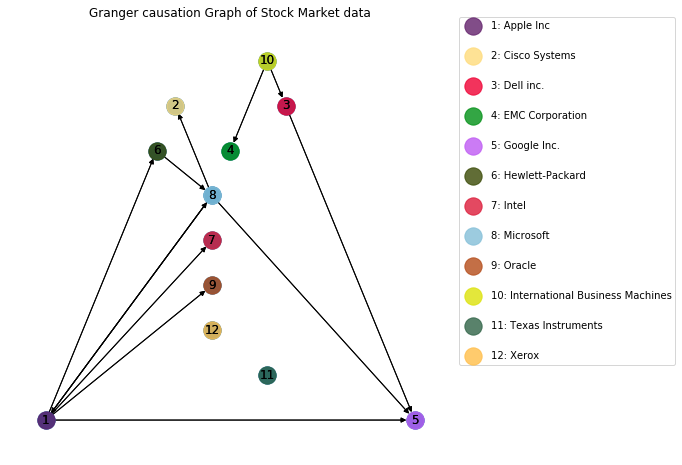

In [23]:
# colors 
colors = []
for i in range(num_companies):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

#for the legend we need inverse dictionary
inv_map = {v: k for k, v in all_stocks.items()}
nodeColorDict = dict(zip(inv_map, colors))


fig, ax = plt.subplots(1, figsize=(8,8))

if nx.check_planarity(G, counterexample=False): # if planar
    pos = nx.planar_layout(G)
    nx.draw(G, pos=pos, with_labels=True)
    
else: # if not planar
    pos = nx.draw_networkx(G)
for nt in inv_map:
    nlist = inv_map[nt]
    ncolor = nodeColorDict[nt] # node color
    nx.draw_networkx_nodes(G, 
                           pos=pos,
                           nodelist= [nlist],
                           ax=ax, 
                           node_color=ncolor,
                           label='{num}: {nt}'.format(nt=nt, num=nlist),
                           alpha=0.8)
h2 = nx.draw_networkx_edges(G, pos=pos)
h3 = nx.draw_networkx_labels(G, pos=pos)
ax.legend(scatterpoints=1, bbox_to_anchor=(1,1.025),loc="upper left", labelspacing=2)
plt.title("Granger causation Graph of Stock Market data")
plt.show()

